<a href="https://colab.research.google.com/github/giozu/FEniCS/blob/main/2D%20problems/2d_poisson_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Equation and problem definition

For a domain $\Omega \subset \mathbb{R}^n$ with boundary $\partial
\Omega = \Gamma_{D} \cup \Gamma_{N}$, the Poisson equation with
particular boundary conditions reads:

$$
\begin{align}
- \nabla^{2} u &= f \quad {\rm in} \ \Omega, \\
u &= 0 \quad {\rm on} \ \Gamma_{D}, \\
\nabla u \cdot n &= g \quad {\rm on} \ \Gamma_{N}. \\
\end{align}
$$

where $f$ and $g$ are input data and $n$ denotes the outward directed
boundary normal. The variational problem reads: find $u \in V$ such
that

$$
a(u, v) = L(v) \quad \forall \ v \in V,
$$

where $V$ is a suitable function space and

$$
\begin{align}
a(u, v) &:= \int_{\Omega} \nabla u \cdot \nabla v \, {\rm d} x, \\
L(v)    &:= \int_{\Omega} f v \, {\rm d} x + \int_{\Gamma_{N}} g v \, {\rm d} s.
\end{align}
$$

The expression $a(u, v)$ is the bilinear form and $L(v)$
is the linear form. It is assumed that all functions in $V$
satisfy the Dirichlet boundary conditions ($u = 0 \ {\rm on} \
\Gamma_{D}$).

In this exercise, we consider:

- $\Omega = [0,2] \times [0,1]$ (a rectangle)
- $\Gamma_{D} = \partial \Omega\$
- $f = 1.0$


## Implementation

The modules that will be used are imported:

In [9]:
import numpy as np

import ufl
from dolfinx import fem, io, mesh, plot
from ufl import ds, dx, grad, inner

from mpi4py import MPI
from petsc4py.PETSc import ScalarType

from dolfinx.io import gmshio # to import gmsh functions

import matplotlib.pyplot as plt

## Initializing notebook plotting
When running a python notebook, a special line is necessary to show the plots.

In [10]:
%matplotlib inline

## Mesh generation and functional spaces
We create the mesh using functions (e.g., {py:func} `create_rectangle<dolfinx.mesh.create_rectangle>`), or we import it from a .msh file (made in gmsh).

Then, we define a finite element space $V$ on the mesh.

The second argument of `FunctionSpace` is a tuple `(family, degree)`, where `family` is the finite element family, and `degree` specifies the polynomial degree. In this case `V` is a space of continuous Lagrange finite elements of degree 1.

To apply the Dirichlet boundary conditions, we find the mesh facets (entities of topological co-dimension 1) that lie on the boundary $\Gamma_D$ using `locate_entities_boundary`. The function is provided with a boolean function that returns `True` for points `x` on the boundary and `False` otherwise.

Lastly, we find the degrees-of-freedom that are associated with the boundary facets using `locate_dofs_topological`, and use `dirichletbc` to create a `DirichletBCMetaClass` class that represents the boundary condition.

In [11]:
# Mesh
# Rectangle
# msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
#                             points=((0.0, 0.0), (2.0, 1.0)), n=(32, 16),
#                             cell_type=mesh.CellType.triangle,)
# Square
# msh = mesh.create_unit_square(MPI.COMM_WORLD, 12, 12, mesh.CellType.quadrilateral)

# Hexagon (from .msh file, generated with gmsh)
# msh, _, _ = gmshio.read_from_msh("esagonino.msh", MPI.COMM_WORLD, gdim = 2)
msh, cell_tags, facet_tags = gmshio.read_from_msh("esagonino.msh", MPI.COMM_WORLD, gdim = 2)

# Boundary conditions
# Create facet to cell connectivity required to determine boundary facets
tdim = msh.topology.dim
fdim = tdim - 1
msh.topology.create_connectivity(fdim, tdim)

# Finite element space, defined on the mesh
V = fem.FunctionSpace(msh, ("Lagrange", 1))

# facets = mesh.locate_entities_boundary(msh, dim=(msh.topology.dim - 1),
#                                        marker=lambda x: np.logical_or(np.isclose(x[0], 0.0),
#                                                                       np.isclose(x[0], 2.0)))
facets = mesh.exterior_facet_indices(msh.topology)

# Degrees of freedom
dofs = fem.locate_dofs_topological(V=V, entity_dim=fdim, entities=facets)
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)


Info    : Reading 'esagonino.msh'...
Info    : 13 entities
Info    : 817 nodes
Info    : 1536 elements
Info    : Done reading 'esagonino.msh'


## Variational problem
The `LinearProblem` object brings together the variational problem, the Dirichlet boundary condition, and the linear solver. In this case an LU solver is sued. The function `solve` computes the solution.

In [12]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)

# f = 10 * ufl.exp(-((x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2) / 0.02)
f = 10.0
# g = ufl.sin(5 * x[0])

a = inner(grad(u), grad(v)) * dx
L = inner(f, v) * dx # + inner(g, v) * ds

problem = fem.petsc.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

# The solution can be written to a file, and visualize it with ParaView or VisIt:
# with io.XDMFFile(msh.comm, "out_poisson/poisson.xdmf", "w") as file:
#     file.write_mesh(msh)
#     file.write_function(uh)

## Visualization
displayed using [pyvista](https://docs.pyvista.org/).


In [13]:
try:
    import pyvista
    cells, types, x = plot.create_vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = uh.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()

except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")


Widget(value="<iframe src='http://localhost:42515/index.html?ui=P_0x7fdfe6d14430_3&reconnect=auto' style='widt…

## Curve plots throughout the mesh
It is possible to plot the solution along a line $y=f(x)$. First, we define the set of points, then we evaluate the finite element solution $u_h$ at these points.

The finite element solution is a linear combination of all degrees of freedom, $u_h = \sum_{i=1}^N c_i \phi_i(x)$, where $c_i$ is the coefficient of $u_i$ and $\phi_i$ is the basis function. We can compute the exact solution at any point in $\Omega$. However, as a mesh consists of a large set of degrees of freedom (i.e. $N$ is large), we want to reduce the number of evaluations of the basis functions. This is efficiently done by creating a bounding box tree of the cells of the mesh, allowing a quick recursive search through the mesh entities.

In [14]:
from dolfinx import geometry

points = np.zeros((3, 101))

# plot along the line y = x
points[0] = np.linspace(0, 1, 101)
points[1] = np.linspace(0, 1, 101)

u_values = []
cells = []
points_on_proc = []

bb_tree = geometry.BoundingBoxTree(msh, msh.topology.dim)

cell_candidates = geometry.compute_collisions(bb_tree, points.T)
colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, points.T)

for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
        
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = uh.eval(points_on_proc, cells)

Widget(value="<iframe src='http://localhost:42515/index.html?ui=P_0x7fdfe6d64250_4&reconnect=auto' style='widt…

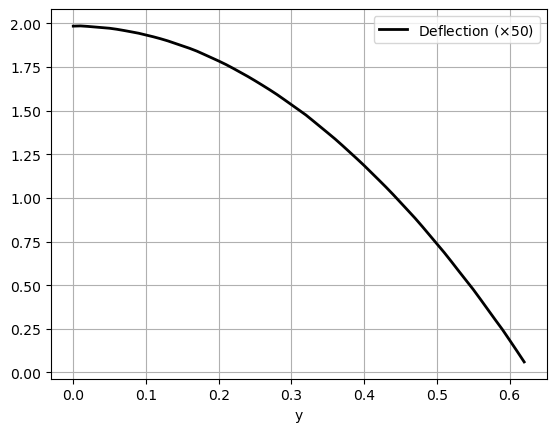

In [15]:
# 2D plot
u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(V)

u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

# Line plot
fig = plt.figure()
plt.plot(points_on_proc[:,1], u_values, "k", linewidth=2, label="Deflection ($\\times 50$)")
plt.grid(True)
plt.xlabel("y")
plt.legend()

## Evaluate the gradient of the solution
We evaluate the gradient of $u_h$ by defining an expression for the gradient and interpolating it on the domain.

In [16]:
grad_u_expr = fem.Expression(grad(uh)[0], V.element.interpolation_points()) # d/dx
grad_u = fem.Function(V)
grad_u.interpolate(grad_u_expr)

# 2D plot
u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(V)

u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = grad_u.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()


Widget(value="<iframe src='http://localhost:42515/index.html?ui=P_0x7fe0185c1d20_5&reconnect=auto' style='widt…